In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [2]:
# Load all necessary CSV files
races = pd.read_csv("races.csv")
results = pd.read_csv("results.csv")
drivers = pd.read_csv("drivers.csv")
constructors = pd.read_csv("constructors.csv")
status = pd.read_csv("status.csv")
constructor_standings = pd.read_csv("constructor_standings.csv")
driver_standings = pd.read_csv("driver_standings.csv")


In [3]:
# Merge results with races to get year and round
df = results.merge(races[['raceId', 'year', 'round', 'circuitId']], on='raceId', how='left')

# Merge driver info
df = df.merge(drivers[['driverId', 'driverRef', 'nationality']], on='driverId', how='left')

# Merge constructor info
df = df.merge(constructors[['constructorId', 'name']], on='constructorId', how='left', suffixes=('', '_constructor'))

# Merge status info
df = df.merge(status, on='statusId', how='left')

# Optional: merge standings (just for feature engineering later, we won’t use them directly for labels)
df = df.merge(driver_standings[['raceId', 'driverId', 'points']], on=['raceId', 'driverId'], how='left', suffixes=('', '_standings'))


In [4]:
# Sort data for correct cumulative operations
df.sort_values(by=['year', 'round', 'driverId'], inplace=True)

# Cumulative points per driver per season
df['cumulative_points'] = (
    df.groupby(['year', 'driverId'])['points']
    .cumsum() - df['points']
)

# Cumulative wins
df['cumulative_wins'] = (
    df.groupby(['year', 'driverId'])['positionOrder']
    .transform(lambda x: (x == 1).cumsum()) - (df['positionOrder'] == 1).astype(int)
)

# Cumulative DNFs (non-statusId 1)
df['cumulative_dnf'] = (
    df.groupby(['year', 'driverId'])['statusId']
    .transform(lambda x: (x != 1).cumsum()) - (df['statusId'] != 1).astype(int)
)

# Average finish position (excluding current race)
df['cumulative_finish'] = df.groupby(['year', 'driverId'])['positionOrder'].cumsum() - df['positionOrder']
df['race_count'] = df.groupby(['year', 'driverId']).cumcount()
df['average_finish'] = df['cumulative_finish'] / df['race_count']

# Drop rows where race_count == 0 (i.e., first race — no history)
df = df[df['race_count'] > 0]

# Final check
df[['year', 'round', 'driverId', 'cumulative_points', 'cumulative_wins', 'cumulative_dnf', 'average_finish']].head()



,year,round,driverId,cumulative_points,cumulative_wins,cumulative_dnf,average_finish
20045,1950,2,579,0.0,0,1,12.0
20047,1950,2,589,0.0,0,1,18.0
20050,1950,2,619,0.0,0,1,6.0
20057,1950,2,627,2.0,0,1,5.0
20059,1950,2,640,0.0,0,1,17.0


In [5]:
# Define input features
features = ['cumulative_points', 'cumulative_wins', 'cumulative_dnf', 'average_finish']

# Define target
target = 'positionOrder'

# Drop any rows with missing values in selected columns
df_model = df[features + [target]].dropna()

# Create X and y
X = df_model[features]
y = df_model[target]

print("Feature sample:")
print(X.head())

print("\nTarget sample:")
print(y.head())

Feature sample:
       cumulative_points  cumulative_wins  cumulative_dnf  average_finish
20045                0.0                0               1            12.0
20047                0.0                0               1            18.0
20050                0.0                0               1             6.0
20057                2.0                0               1             5.0
20059                0.0                0               1            17.0

Target sample:
20045     1
20047     3
20050     6
20057    13
20059    15
Name: positionOrder, dtype: int64


In [6]:
# Add driverStandingsPos if not already in df
if 'driverStandingsPos' not in df.columns:
    df = df.merge(driver_standings[['raceId', 'driverId', 'position']].rename(columns={'position': 'driverStandingsPos'}),
                  on=['raceId', 'driverId'], how='left')

# Add constructorStandingsPos if not already in df
if 'constructorStandingsPos' not in df.columns:
    df = df.merge(constructor_standings[['raceId', 'constructorId', 'position']].rename(columns={'position': 'constructorStandingsPos'}),
                  on=['raceId', 'constructorId'], how='left')

# Add wins (target variable) if not already in df
if 'wins' not in df.columns:
    df = df.merge(constructor_standings[['raceId', 'constructorId', 'wins']],
                  on=['raceId', 'constructorId'], how='left')

# Define feature list
features = [
    'grid', 'positionOrder', 'laps', 'milliseconds',
    'driverStandingsPos', 'constructorStandingsPos',
    'points', 'statusId'
]

# Check for missing values
print("Missing values before cleaning:")
print(df[features + ['wins']].isnull().sum())

# Drop rows with missing values
df_clean = df[features + ['wins']].dropna()

# Separate input and output
X = df_clean[features]
y = df_clean['wins']

print("\nAfter dropping missing values:")
print(X.isnull().sum())
print("Shape after cleaning:", X.shape)




Missing values before cleaning:
grid                         0
positionOrder                0
laps                         0
milliseconds                 0
driverStandingsPos         233
constructorStandingsPos    926
points                       0
statusId                     0
wins                       926
dtype: int64

After dropping missing values:
grid                       0
positionOrder              0
laps                       0
milliseconds               0
driverStandingsPos         0
constructorStandingsPos    0
points                     0
statusId                   0
dtype: int64
Shape after cleaning: (22462, 8)


In [7]:
# Replace '\\N' with NaN
X = X.replace('\\N', np.nan)

# Convert all columns to numeric (forces non-numeric strings to NaN)
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
X = X.dropna()
y = y[X.index]  # Align y with cleaned X


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training shape:", X_train_scaled.shape)
print("Testing shape:", X_test_scaled.shape)


Training shape: (5552, 8)
Testing shape: (1388, 8)


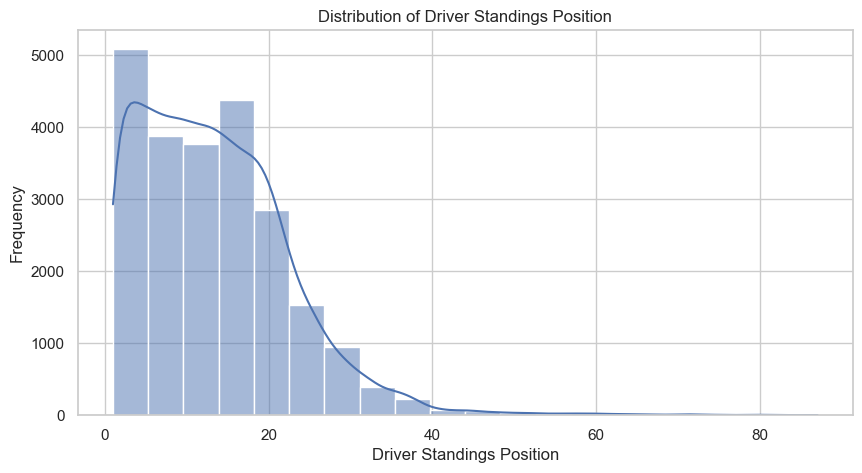

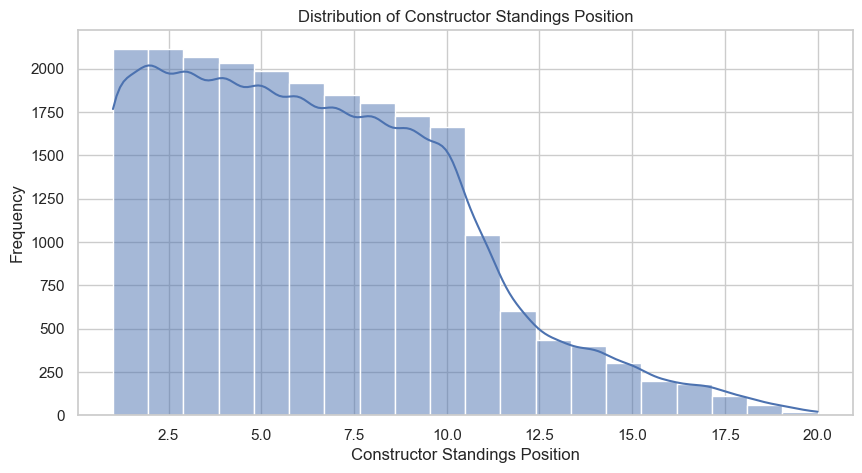

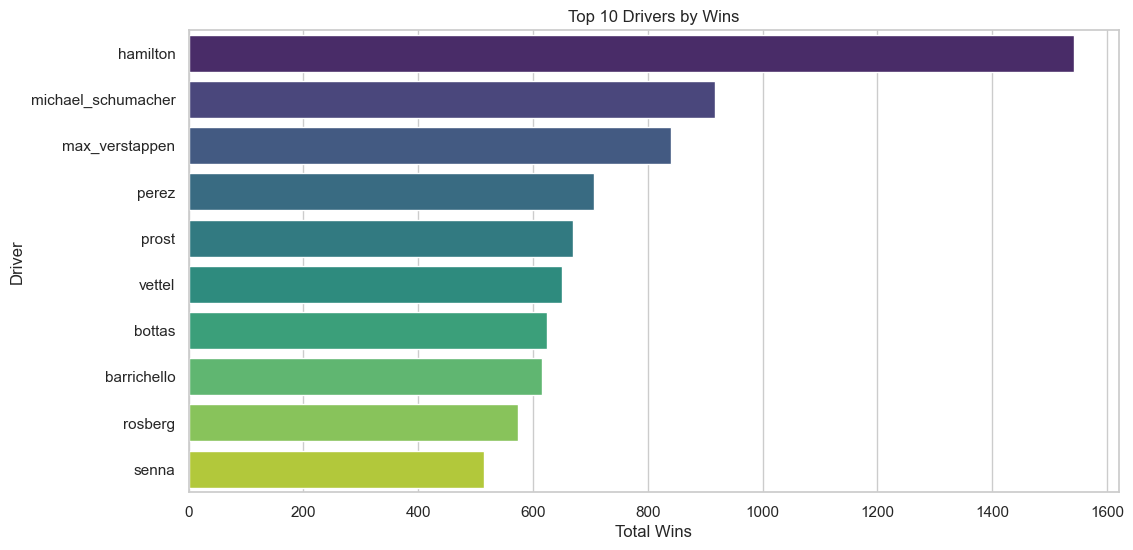

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# 1. Distribution of driver standings
plt.figure(figsize=(10, 5))
sns.histplot(df['driverStandingsPos'].dropna().astype(int), bins=20, kde=True)
plt.title("Distribution of Driver Standings Position")
plt.xlabel("Driver Standings Position")
plt.ylabel("Frequency")
plt.show()

# 2. Distribution of constructor standings
plt.figure(figsize=(10, 5))
sns.histplot(df['constructorStandingsPos'].dropna().astype(int), bins=20, kde=True)
plt.title("Distribution of Constructor Standings Position")
plt.xlabel("Constructor Standings Position")
plt.ylabel("Frequency")
plt.show()

# 3. Wins by Top 10 Drivers
top_drivers = df.groupby('driverRef')['wins'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_drivers.values, y=top_drivers.index, palette='viridis')
plt.title("Top 10 Drivers by Wins")
plt.xlabel("Total Wins")
plt.ylabel("Driver")
plt.show()



In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the ANN model
ann = Sequential()
ann.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
ann.add(Dense(64, activation='relu'))
ann.add(Dense(32, activation='relu'))
ann.add(Dense(1, activation='linear'))  # for regression

# Compile the model
ann.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = ann.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


C:\Users\abhir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.2199 - mae: 1.5071 - val_loss: 4.9020 - val_mae: 1.1817
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8502 - mae: 1.1765 - val_loss: 9.4640 - val_mae: 1.2050
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7274 - mae: 1.1346 - val_loss: 5.1725 - val_mae: 1.1196
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8130 - mae: 1.1461 - val_loss: 6.4525 - val_mae: 1.1244
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8953 - mae: 1.1204 - val_loss: 4.3308 - val_mae: 1.1020
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3123 - mae: 1.0884 - val_loss: 11.9773 - val_mae: 1.2434
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2213 - mae: 1.0358 - val_loss: 3.7421 - val_mae: 1.0835
Epoch 8/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7681 - mae: 1.1364 - val_loss: 25.3016 - val_mae: 1.1675
Epoch 9/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

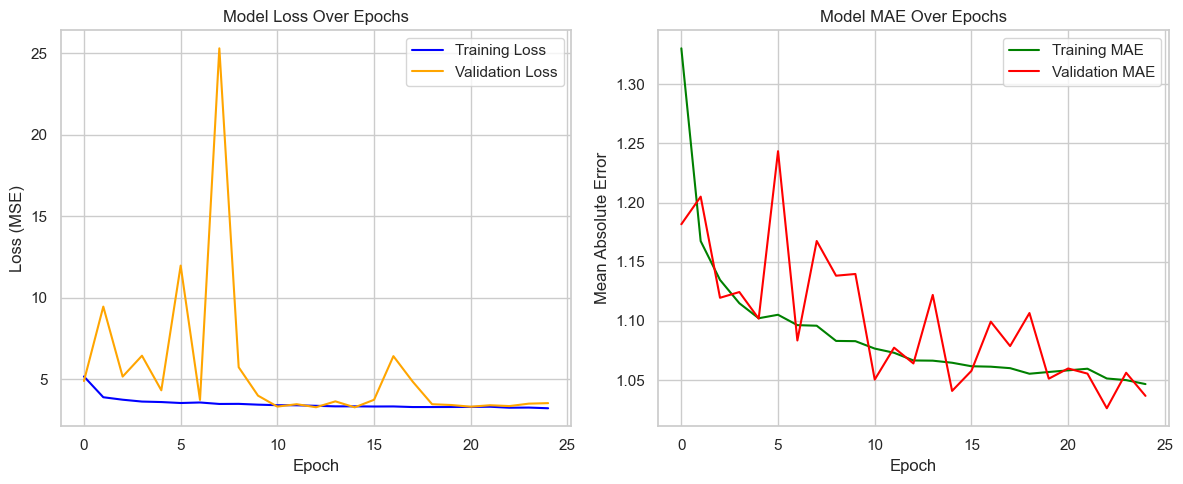

In [11]:
import matplotlib.pyplot as plt

# Plot the training & validation loss values
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', color='green')
plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# 1. Create input using the same feature names and order
custom_input = pd.DataFrame([{
    'grid': 3,
    'positionOrder': 2,
    'laps': 56,
    'milliseconds': 5400000,
    'driverStandingsPos': 2,
    'constructorStandingsPos': 1,
    'points': 15,
    'statusId': 1
}])

# 2. Scale the input
custom_input_scaled = scaler.transform(custom_input)

# 3. Predict using the trained ANN model
predicted_output = ann.predict(custom_input_scaled)

# 4. Output result
print(f"Predicted wins (approx.): {predicted_output[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
Predicted wins (approx.): 6.56
